In [17]:
#All the necessary imports
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from keras.applications.vgg19 import VGG19 #This is to use a pre-trained network VGG19

%matplotlib inline

In [39]:
"""
This cell consists of a class "CONFIG" which has all the necessary constants used later.
Also there are helper functions like "load_vgg_model", "generate_noise_image", "reshape_and_normalize_image", "save_image"
"""

class CONFIG:
    IMAGE_WIDTH = 400                                                   #The width of input image will be rescaled to 400.
    IMAGE_HEIGHT = 300                                                  #The height of input image will be rescaled to 300.
    COLOR_CHANNELS = 3
    
    NOISE_RATIO = 0.8                                                   #This ratio will affect how noisy our initial random 
                                                                        #image will be compared to content image.
    
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))     #These means were already calculated during training of VGG19
                                                                        #network based on various images. So here the mean is of each channel i.e Red,Green,Blue
                                                                        #and will be used for normalizing the input



def load_vgg_model():
    """
    VGG19 actually uses maxpool at different layers, but the paper "A neural algorithm for artistic style by Leon A. Gatys, Alexander S.Ecker, Mathias Bethge
    indicates that using AveragePooling yields better results. Also the last few fully connected layers of VGG19 are not used. This function is mainly to explicitly
    replace MaxPool with AveragePooling and also to ignore the last fully connected layers. Also individual layers will be stored in a python dictionary to make things
    easy
    """
    
    vgg = VGG19(weights="imagenet")

    vgg_layers = vgg.layers
    
    def _weights(layer):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[layer].get_weights()
        W = wb[0]
        b = wb[1]
     
        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function applied on a given layer
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b  #The same weights are used as in VGG19 and strides of length 1

    def _conv2d_relu(prev_layer, layer):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    
    
    #Following variable "graph" is just a dictionary to store intermediate VGG layers
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, 300, 400, 3)), dtype = 'float32')  #This is just creating a TF variable of shape as our re-scaled input image
                                                                                   #and data type will be float32
    graph['conv1_1']  = _conv2d_relu(graph['input'], 1)
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2)
    graph['avgpool1'] = _avgpool(graph['conv1_2'])                                 #This is where we replace MaxPool with AvgPool in VGG19
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 4)
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 5)
    graph['avgpool2'] = _avgpool(graph['conv2_2'])                                 #Replaced MaxPool with AvgPool
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 7)
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 8)
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 9)
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 10)
    graph['avgpool3'] = _avgpool(graph['conv3_4'])                                 #Replaced MaxPool with AvgPool
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 12)          
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 13)
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 14)
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 15)
    graph['avgpool4'] = _avgpool(graph['conv4_4'])                                 #Replaced MaxPool with AvgPool
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 17)
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 18)
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 19)
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 20)
    graph['avgpool5'] = _avgpool(graph['conv5_4'])                                 #Replaced MaxPool with AvgPool
                                                                                   #Also ignored the fully-connected layers of VGG19
    
    return graph


  
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    #input_image = input_image - CONFIG.MEANS
    
    return input_image
  
  
def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    
    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS
    
    return image


def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)


In [19]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost. a_C and a_G are tensors of shape (1, height, width, channels ). a_C is the 
    content of original image and a_G is content of generated image.
    It returns a scalar quantity as cost.
    """

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G and unroll the tensors. Before reshape it is required to use transpose because 
    # here we need to calculate the differences between corresponding channels of the "content image" and "generated image".
    # i.e. the difference between channel 1 of "content" image and "generated image", difference between channel 2 of "content image" and
    # "generated image" and so on.
   
    a_C_unrolled = tf.reshape(tf.transpose(a_C, perm=[0,3,1,2]), [m,n_C, n_H*n_W])
    a_G_unrolled = tf.reshape(tf.transpose(a_G, perm=[0,3,1,2]), [m,n_C, n_H*n_W])
    
    # compute the cost as mentioned in the paper "Neural Style Transfer"
    J_content = tf.divide(tf.reduce_sum(tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))),2)
    

    return J_content

In [20]:
def gram_matrix(A):
    """
    Calculate Gram matrix as mentioned in the problem statement.
    Gram matrix basically gives a similarity measure between vectors. So here we need to find correlation
    between different channels. i.e. how often any given activation of a channel occurs together with that same activation 
    but from a different channel. This will represent style of our image.
    So input here is a matrix A of shape (channels, height x width). This because once we have our any given VGG layer in this form,
    we can simply calculate "GRAM" matrix by taking dot products with transpose i.e. v.v'. This we will find correlation between different
    channels of a given layer. If features correlate, then v.v' will be large or else small.
    
    Returns Gram matrix of A, of shape (channels, channels) because A is (channels, height x width) and A' will be (height x width, channels) and so A.A' will
    be (channels, channels)
    """
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [21]:
def compute_layer_style_cost(a_S, a_G):
    """
    Computes the style cost. a_C and a_G are tensors of shape (1, height, width, channels ). a_S is a layer of VGG of
    style image and a_G is that same layer of VGG but of generated image.
    It returns a scalar quantity as cost similar to content cost function above
    """
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Similar to content cost do the following,
    # Reshape a_S and a_G and unroll the tensors. Before reshape it is required to use transpose because 
    # here we need to calculate the differences between corresponding channels of the "content image" and "generated image".
    # i.e. the difference between channel 1 of "content" image and "generated image", difference between channel 2 of "content image" and
    # "generated image" and so on.
    a_S = tf.reshape(tf.transpose(a_S, perm=[0,3,1,2]), [n_C, n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G, perm=[0,3,1,2]), [n_C, n_H*n_W])

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Compute the cost as Mean Squared Error (MSE) as mentioned in the problem statement.  
    J_style_layer = tf.losses.mean_squared_error(GS, GG)
    
    # Here we could also use cost as mentioned in the paper "Neural Style Transfer".
    # J_style_layer = tf.divide(tf.reduce_sum(tf.reduce_sum(tf.square(tf.subtract(GS, GG)))), 4 * tf.square(tf.to_float(n_C)) * tf.square(tf.to_float(n_H*n_W)))
    
    

    
    
    return J_style_layer

In [22]:
#As mentioned in the problem statement, style matrix can be calculated for different layers from VGG network. 
#Following layers will be be used.

STYLE_LAYERS = [ ('conv1_1'), ('conv2_1'), ('conv3_1'), ('conv4_1'), ('conv5_1')]

In [23]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers. model is the VGG model that is passed to get the layers.
    Returns J_style which is overall style cost from selected layers as a scalar
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out. This is because the style from style image
        # will be fixed through out training.
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add all J_style_layer for overall style cost
        J_style += J_style_layer

    return J_style


In [24]:
def total_variation_cost(generated_image):
  """
  As mentioned in problem statement, variation loss is also required which basically calculates the noise
  present in the image by calculating differences of neighbouring pixel values in an image.
  
  Returns J_variation a scalar value which is sum of variation losses.
  """
  
  J_variation = tf.reduce_sum(tf.image.total_variation(generated_image))
  
  return J_variation

In [25]:
def total_cost(J_content, J_style, J_variation, alpha = 10, beta = 40):
    """
    Computes the total cost function. alpha and beta are weights that basically decide how much importance 
    should be given to J_content and J_style
    
    Returns total cost J as scalar
    """
    J = (alpha*J_content) + (beta*J_style) + J_variation
    
    return J


In [26]:
# From here, use the tensorflow constructs of resetting any default graph, using interactive session as it will automatically 
# create a default session. Also from here we start constructing our computation
# graph by using our vgg model, then passing "Content" image and "Style" image to fix values in from respective layers inside our computation
# graph. Only the generated image values will be dynamic which will keep changing during execution of the computation graph.

tf.reset_default_graph()

sess = tf.InteractiveSession()


/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [27]:
# Now read content image from google drive and normalize and reshape using helper function.
content_image = scipy.misc.imread("japanese_garden_small.jpg")
content_image = reshape_and_normalize_image(content_image)


# Same for style image
style_image = scipy.misc.imread("picasso_selfportrait_small.jpg")
style_image = reshape_and_normalize_image(style_image)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


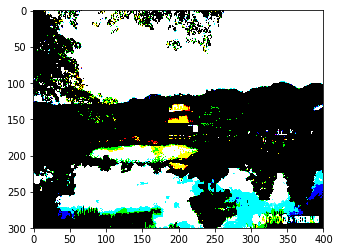

In [40]:
# Content Image without noise

generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


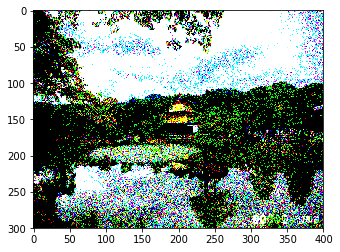

In [29]:
# Content Image with some noise i.e. noise_ratio 0.8

generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [30]:
# Load VGG19 model using helper function
model = load_vgg_model()

Instructions for updating:
Colocations handled automatically by placer.


In [31]:
# In this cell, construct a node in computation graph which is "compute_content_cost". Also fix the layer
# value of the original content in the node of the graph because only the content of generated image will
# keep changing during graph execution.

# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2 because this is decided to be responsible for content representation.
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected. We actually do sess.run on this, because we will use these value
# and fix it inside the node of computation graph
a_C = sess.run(out)


# But for the content of generated image, we only reference the layer "conv4_2" and don't run sess.run on this. Because the a_G value will be 
# dynamic i.e. content of generated image will keep updating during backpropagation.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

#So after all the above lines in this cell, a node will be created in our computation graph called "compute_content_cost".

In [32]:
# Similarly in this cell, construct a node in computation graph which is "compute_style_cost". Also fix the layer
# value of the original style in the node of the graph because only the style of generated image will
# keep changing during graph execution. This is done inside the "compute_style_cost" function itself.

# Assign the input of the model to be the "style" image
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

# After above 2 lines, a node called "compute_style_cost" will be created in our computation graph.

Instructions for updating:
Use tf.cast instead.


In [33]:
# Similarly construct node in graph for "total_variation_cost". Simply create a variable of zeros same size as generated image.
# Later when we run the graph, replace it with the latest generated image.
gen_image = tf.Variable(np.zeros((1, 300, 400, 3)), dtype = 'float32')
J_variation = total_variation_cost(gen_image)

In [34]:
# Now create node for "total_cost" in computation graph.
J = total_cost(alpha=10000, beta=10,J_content=J_content, J_style=J_style, J_variation=J_variation)


In [35]:
# Use AdamOptimizer during backpropagation
optimizer = tf.train.AdamOptimizer(2.0)

train_step = optimizer.minimize(J)

Instructions for updating:
Use tf.cast instead.


In [36]:
# Following function actually initializes variables of our graph, assigns the random generated image as input and 
# finally executes the computation graph.

def model_nn(sess, input_image, num_iterations = 200):
    # Initialize global variables
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Assign the random noisy image as input
    sess.run(model['input'].assign(input_image))
    
    # Also assign the noisy image to gen_image to calculate variation cost
    sess.run(tf.assign(gen_image, input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']. 
        # The initial values change because of backpropagation.
        generated_image = sess.run(model['input'])

        # Assign the latest generated image to calculate variation cost
        sess.run(tf.assign(gen_image, generated_image))
        
        # save generated image after every 20 iterations locally 
        if i%20 == 0:
            # save current generated image locally
            save_image(str(i) + ".png", generated_image)
    
    
    #Cost after 100 iterations
    Jt, Jc, Js = sess.run([J, J_content, J_style])
    print("Iteration " + str(i) + " :")
    print("total cost = " + str(Jt))
    print("content cost = " + str(Jc))
    print("style cost = " + str(Js))
    
    return generated_image

In [38]:
# Run the computational graph
model_nn(sess, generated_image)

### The output images are stored under directories "generated_output_without_noise" and "generated_output_with_noise"
Images were stored after every 20 iterations. Total no.of interations was 200.<br>
"generated_output_without_noise" folder consists of style applied to content image without noise. <br>
"generated_output_with_noise" folder consists of style applied to content image with noise.

### Cost details without noise in content image:
Iteration 199 :
total cost = 1.0625515e+16
content cost = 39688980000.0
style cost = 354170600000000.0

### Cost details with noise in content image:
Iteration 199 :
total cost = 4.8557423e+16
content cost = 44521312000.0
style cost = 1618565800000000.0

# Project Summary:
<pre>
<h5>
1.) This project is a great example of how deep pre-trained networks like VGG which is initially trained to do
classification is used for completely different task like "Style Transfer". This is achieved by simply ignoring the last fully connected layers of VGG and only making use of feature representations of any layer before the
fully-connected layers. So this shows that it is not always necessary to train huge networks from scratch.
Instead we can use pre-trained networks in various ways.

2.) The general idea was to create an image such that , 
Generated_Image = Content of one image + Style of another image.

For this, to get the exact content of content image, it is preferred to select a deeper layer instead of 
shallow layer, as deep layers have higher level features, once we pass the content image into VGG.

For the style, different layers of VGG networks were selected, once we pass style image into VGG. Then the 
style was represented using the concept of "Gram" matrix. Gram matrix is a type of similarity measure between
vectors. So for a give style image, the gram matrix of that image at a given layer of VGG is the correlation
between different channels in that layer. So if there are 3 channels at a given layer, then gram matrix will
calculate the correlation between activation 1 of channel 1 and activation 1 of channel 2, similarly,
correlation between activation 2 of channel 1 and activation 2 of channel 2 and so on.

3.) Suppose for the "Content Cost" layer "L" was selected, then cost will be,
    
    Content_Cost = sum( (G[L] - C[L])^2 ) / 2,
    
    where "G" is generated image and "C" is content image.
    
    For "Style Cost", different layers are selected from VGG and for each layer the gram matrix is 
    calculated.
    
    Gram matrix of any two vectors is a.a' where a' is transpose of a. Then calculate the Mean Squared Error
    of gram matrix between generated image and style image.
    
    Style_Cost = sum( (Gram(G) - Gram(S))^2 ) / N
    where N is length of vector G or S because both should be same length.
    
    Also this has to be done for various layers, so 
    
    total_style_cost = sum(style_cost of all layers).
    
    Finally, the total_cost is,
    
    total_cost = (alpha)*Content_Cost + (beta)*total_style_cost + total_variation_cost
    where alpha and beta are simply weights deciding how much importance to be given to content and style.
    total_variation_cost helped in removing noise from generated image.
    
 4.) As mentioned in the paper "A neural algorithm for artistic style by Leon A. Gatys, Alexander S.Ecker,
 Mathias Bethge, better results were obtained by replacing the MaxPool layers with AveragePool in VGG19, so
 this is done in the helper function load_vgg_model().
 
 5.) In the gram matrix, it can be seen that the diagonal of matrix will have high values because correlation
 is found between the same vector. This indicates how strong a feature is in that given layer.
 
 6.) As mentioned in the problem statement, variation loss was also added to the total cost. This improved
 clarity of output images, as variation_loss reduces noise in the image.
 
 7.) For the optimization part during backpropagation, "AdamOptimizer" was used over "gradient descent", as it reduces fluctuations during descent by using concept of moving average.
 
 8.) For style cost, I used Mean Square Error. According to the paper, cost also has other normalization terms. This may not exactly improve quality of image, but will help in efficient learning.
 
 9.) NOISE_RATIO constant was used to decide how much of noise will be in the initial content image.
 NOISE_RATIO of 1 will give complete randomly generated noise image. But learning becomes very difficult from
 here with many iterations. Without access to GPU, this will be time consuming. So by adding around 80% noise
 to content image, I was able to get reasonable results.
 
 10.) Final generated images are under folder "generated_output_with_noise" and
 "generated_output_without_noise"
</h5>
</pre>


<h2>Citations</h2>
"A neural algorithm for artistic style by Leon A. Gatys, Alexander S.Ecker, Mathias Bethge